<a href="https://colab.research.google.com/github/lucacerab/DSEthesis-transformers/blob/main/SUBJ_final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Finetuning BERT for subjective/objective sentence detection

Dataset: http://www.cs.cornell.edu/people/pabo/movie-review-data/

labels: 0 = objective sentence; 1 = subjective sentence

SOTA: https://paperswithcode.com/sota/subjectivity-analysis-on-subj

## Load data

* quote.tok.gt9.5000 contains 5000 subjective sentences (or snippets);
* plot.tok.gt9.5000 contains 5000 objective sentences.  

In [ ]:
!wget 'http://www.cs.cornell.edu/people/pabo/movie-review-data/rotten_imdb.tar.gz'

--2021-08-27 13:01:09--  http://www.cs.cornell.edu/people/pabo/movie-review-data/rotten_imdb.tar.gz
Resolving www.cs.cornell.edu (www.cs.cornell.edu)... 132.236.207.36
Connecting to www.cs.cornell.edu (www.cs.cornell.edu)|132.236.207.36|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 519599 (507K) [application/x-gzip]
Saving to: ‘rotten_imdb.tar.gz’

rotten_imdb.tar.gz  100%[===================>] 507.42K  2.64MB/s    in 0.2s    

2021-08-27 13:01:10 (2.64 MB/s) - ‘rotten_imdb.tar.gz’ saved [519599/519599]



In [ ]:
!tar -xzvf '/content/rotten_imdb.tar.gz' -C '/content/' && rm '/content/rotten_imdb.tar.gz'

quote.tok.gt9.5000
plot.tok.gt9.5000
subjdata.README.1.0


In [ ]:
import pandas as pd 

def read_data(path, label):
  temp = []
  
  with open(path, 'r', encoding='latin-1') as f:
    text = f.read()
    for line in text.split('\n'):
      if line != '':
        temp.append(line.strip())
  
  temp_labels = [label] * len(temp)

  df = pd.DataFrame(list(zip(temp, temp_labels)), columns =['sentence', 'label'])
  
  return df

In [ ]:
obj_df = read_data('/content/plot.tok.gt9.5000', 0)
subj_df = read_data('/content/quote.tok.gt9.5000', 1)

In [ ]:
df = pd.concat([obj_df, subj_df])
print('shape:', df.shape)
print()
print('check null values:')
print(df.isna().sum())
print()
df.head()

shape: (10000, 2)

check null values:
sentence    0
label       0
dtype: int64



,sentence,label
0,the movie begins in the past where a young boy...,0
1,emerging from the human psyche and showing cha...,0
2,spurning her mother's insistence that she get ...,0
3,amitabh can't believe the board of directors a...,0
4,"she , among others excentricities , talks to a...",0


In [ ]:
# shuffling dfs
df = df.sample(frac=1, random_state=123).reset_index(drop=True)

In [ ]:
df.head()

,sentence,label
0,is this challenge too much for even the amazin...,0
1,"chris , a radio dj , and his wife , katrin , w...",0
2,"off the hook is overlong and not well-acted , ...",1
3,ruled by instant gratification and material de...,0
4,but someone breaks the link before they have f...,0


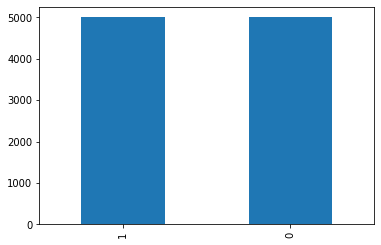

In [ ]:
df.label.value_counts().plot(kind='bar')

### Split train 80% and test 20%

In [ ]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(df.sentence.values, df.label.values, 
                                                    test_size=.2, random_state=123, 
                                                    stratify=df.label.values)

In [ ]:
train_df = pd.DataFrame(list(zip(train_x, train_y)), columns=['sentence', 'label'])
train_df.shape

(8000, 2)

In [ ]:
test_df = pd.DataFrame(list(zip(test_x, test_y)), columns=['sentence', 'label'])
test_df.shape

(2000, 2)

In [ ]:
print('train labels:')
print(train_df.label.value_counts())
print()
print('test labels:')
print(test_df.label.value_counts())

train labels:
1    4000
0    4000
Name: label, dtype: int64

test labels:
1    1000
0    1000
Name: label, dtype: int64


## Preparing data for BERT

In [ ]:
%%capture
!pip install transformers

In [ ]:
from transformers import BertTokenizer

tokenizer = BertTokenizer.from_pretrained("bert-base-cased")

Downloading:   0%|          | 0.00/213k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/29.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/436k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [ ]:
import numpy as np

In [ ]:
# input for BERT should be ids and attention mask
def bert_encode(df, max_len):
  num_samples = len(df)

  X_ids = np.zeros((num_samples, max_len))
  X_mask = np.zeros((num_samples, max_len))
  

  for i, row in df.iterrows():
      encoded = tokenizer.encode_plus(row['sentence'], max_length=max_len,
                                      truncation=True, padding='max_length', add_special_tokens=True)    
      X_ids[i, :] = encoded['input_ids']
      X_mask[i, :] = encoded['attention_mask']
  return X_ids, X_mask

In [ ]:
#length of sentences
max_len = 128

In [ ]:
#train_input_ids, train_attention_masks = bert_encode(train_df, max_len)
train_input = bert_encode(train_df, max_len)
test_input = bert_encode(test_df, max_len)

In [ ]:
train_input[0][0]

array([ 101.,  107., 1103., 6821.,  112.,  188., 1207., 3459.,  107.,
       3471., 1114.,  170., 3014., 2197.,  119.,  119.,  119.,  119.,
       1218.,  117., 1120., 1655., 1115.,  112.,  188., 1103., 2197.,
        119.,  102.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,    0.,
          0.,    0.]

In [ ]:
train_input[1][0]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0.])

In [ ]:
tokenizer.decode(train_input[0][0])

'[CLS] " the emperor\'s new clothes " begins with a simple plan.... well, at least that\'s the plan. [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]'

In [ ]:
train_labels = train_df.label.values
test_labels = test_df.label.values

In [ ]:
train_df.head(1)

,sentence,label
0,""" the emperor's new clothes "" begins with a si...",1


## Building the model

In [ ]:
from transformers import TFAutoModel

bert = TFAutoModel.from_pretrained('bert-base-cased')

bert.summary()

Downloading:   0%|          | 0.00/527M [00:00<?, ?B/s]

Some layers from the model checkpoint at bert-base-cased were not used when initializing TFBertModel: ['nsp___cls', 'mlm___cls']
- This IS expected if you are initializing TFBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
All the layers of TFBertModel were initialized from the model checkpoint at bert-base-cased.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFBertModel for predictions without further training.


Model: "tf_bert_model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bert (TFBertMainLayer)       multiple                  108310272 
Total params: 108,310,272
Trainable params: 108,310,272
Non-trainable params: 0
_________________________________________________________________


In [ ]:
#define hyperparms
import tensorflow as tf
from tensorflow.keras.optimizers import Adam

drop = 0.6

optimizer = Adam(learning_rate=2e-5)
loss = 'binary_crossentropy'

#fine tune bert
trainable = True

In [ ]:
from tensorflow.keras.layers import Dense, Input, Dropout
from tensorflow.keras.models import Model

def create_model(bert):
  input_ids = Input(shape=(max_len,), name="input_word_ids", dtype='int32')
  attention_masks = Input(shape=(max_len,), name="input_mask", dtype='int32')

  embeddings = bert.bert([input_ids, attention_masks])[1]

  x = Dense(256, activation='relu')(embeddings)
  dropout = Dropout(drop, name='dropout')(x)
  output = Dense(1, activation='sigmoid', name='outputs')(dropout)
  
  model = Model(inputs = [input_ids, attention_masks], outputs = output)
  model.layers[3].trainable = trainable
  model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

  return model

In [ ]:
model = create_model(bert)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 128)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 128)]        0                                            
__________________________________________________________________________________________________
bert (TFBertMainLayer)          TFBaseModelOutputWit 108310272   input_word_ids[0][0]             
                                                                 input_mask[0][0]                 
__________________________________________________________________________________________________
dense (Dense)                   (None, 256)          196864      bert[0][1]                   

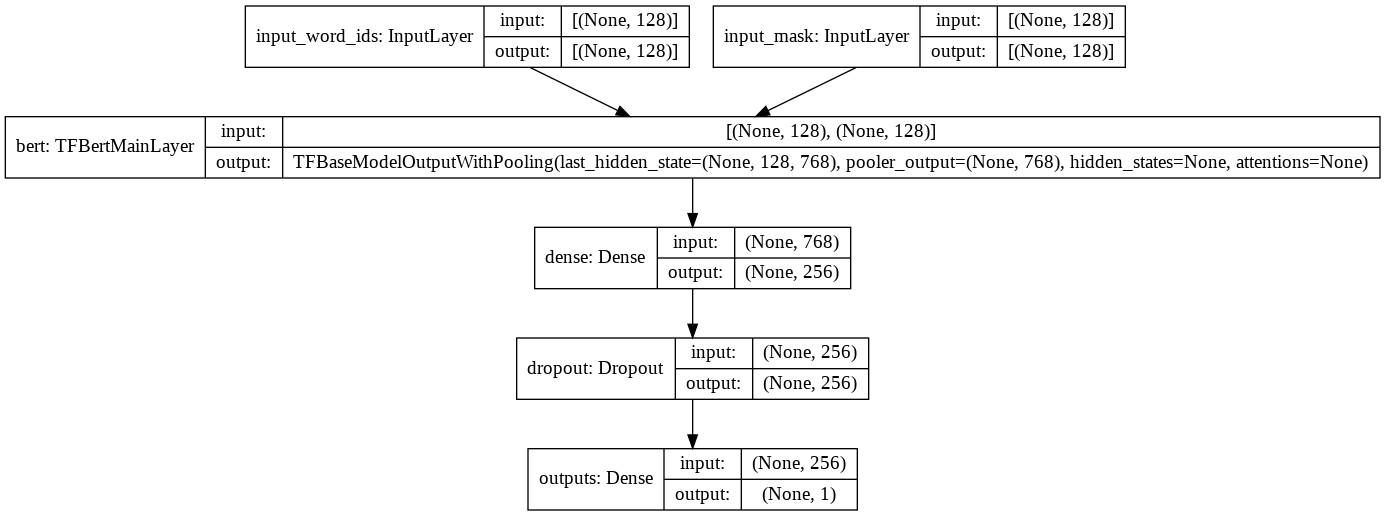

In [ ]:
from keras.utils.vis_utils import plot_model

plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

In [ ]:
epochs = 3
batch_size = 16

history = model.fit(train_input, train_labels,
                    epochs=epochs, batch_size=batch_size)

Epoch 1/3
500/500 [==============================] - 408s 791ms/step - loss: 0.2033 - accuracy: 0.9209
Epoch 2/3
500/500 [==============================] - 396s 791ms/step - loss: 0.0587 - accuracy: 0.9825
Epoch 3/3
500/500 [==============================] - 396s 791ms/step - loss: 0.0271 - accuracy: 0.9910


In [ ]:
model.evaluate(test_input, test_labels)

63/63 [==============================] - 36s 525ms/step - loss: 0.1593 - accuracy: 0.9575


[0.15931935608386993, 0.9574999809265137]

In [ ]:
result = model.predict(test_input)

In [ ]:
result = np.round(result).astype(int)

In [ ]:
result

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [0]])

In [ ]:
test_df.head()

,sentence,label
0,the contents of which will decide the fate of ...,0
1,"but now , hogwarts students are strangely bein...",0
2,a real step forward for the digital video revo...,1
3,at times he seems to share nicholas's fascinat...,0
4,"these movies were the first adult movies , mos...",0


In [ ]:
from sklearn.metrics import accuracy_score

print('accuracy:', accuracy_score(test_df.label, result))

accuracy: 0.9575


In [ ]:
from sklearn.metrics import f1_score

print('f1 macro', f1_score(test_df.label, result, average='macro'))
print('f1 micro', f1_score(test_df.label, result, average='micro'))
print('f1 weighted', f1_score(test_df.label, result, average='weighted'))

f1 macro 0.9574897869213079
f1 micro 0.9575
f1 weighted 0.957489786921308


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(test_df.label, result))

              precision    recall  f1-score   support

           0       0.94      0.97      0.96      1000
           1       0.97      0.94      0.96      1000

    accuracy                           0.96      2000
   macro avg       0.96      0.96      0.96      2000
weighted avg       0.96      0.96      0.96      2000



In [ ]:
model.save('SUBJ_final.h5')

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!cp /content/SUBJ_final.h5 /content/drive/MyDrive/

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(y_true, y_pred, classes,
                          normalize=False,
                          title=None,
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    # Compute confusion matrix
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

    fig, ax = plt.subplots()

    # Set size
    fig.set_size_inches(12.5, 7.5)
    im = ax.imshow(cm, interpolation='nearest', cmap=cmap)
    ax.figure.colorbar(im, ax=ax)
    ax.grid(False)

    # We want to show all ticks...
    ax.set(xticks=np.arange(cm.shape[1]),
           yticks=np.arange(cm.shape[0]),
           # ... and label them with the respective list entries
           xticklabels=classes, yticklabels=classes,
           title=title,
           ylabel='True label',
           xlabel='Predicted label')

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
             rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
        for j in range(cm.shape[1]):
            ax.text(j, i, format(cm[i, j], fmt),
                    ha="center", va="center",
                    color="white" if cm[i, j] > thresh else "black")
    fig.tight_layout()
    return ax

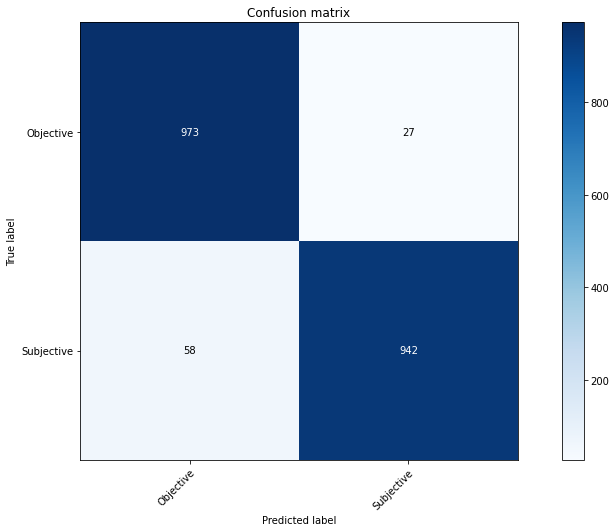

In [ ]:
classes = ['Objective', 'Subjective']
plot_confusion_matrix(test_df.label, result, classes=classes, normalize=False, title='Confusion matrix')
plt.show()